# 4.1. Простые решения уравнения фильтрации с использованием преобразования Лапласа

Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.2 от 11.11.2024

Хабибуллин Ринат 2023 г.

---

# Содержание:
* [1. Уравнение фильтрации и его решения в пространстве Лапласа](#1)
    * [1.1. Общее решение уравнения фильтрации в пространстве Лапласа](#1.1.-Общее-решение-уравнения-фильтрации-в-пространстве-Лапласа)
    * [1.2.Модифицированные функции Бесселя. Манипуляции с использованием `scipy.special` и `sympy`](#1.2.Модифицированные-функции-Бесселя.-Манипуляции-с-использованием-`scipy.special`-и-`sympy`)
    * [1.3. Построение общего решения с использованием `sympy`](#13)
    * [1.4. Построение частных решений уравнения фильрации. Решение радиального притока с конечным радиусом скважины в бесконечном пласте](#14)
* [2. Решение линейного стока - простейшее решение](#412)
* [3. Построение и исследование решения линейного стока с использованием обратного преобразования Лапласа](#413)
* [4. Решение для конечного радиуса скважины](#414)

In [2]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

import sympy as sp

# 1. Уравнение фильтрации и его решения в пространстве Лапласа <a class="anchor" id="1"></a>

Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right] 
$$

где введены следующие безразмерные переменные
* $r_D$ - безразмерное расстояние от центра скважины
* $t_D$ - безразмерное время
* $p_D$ - безразмерное давление

Соответствующие определения безразмерных переменных

$$ r_D = \frac{r}{r_w}$$
$$ t_D = \frac{0.00036 kt}{\phi \mu c_t r_w^2}$$
$$ p_D = \frac{kh}{ 18.41 q_s B \mu} \left( p_i - p \right)$$

где в свою очередь 
* $q_s$ - дебит скважины на поверхности, приведенный к нормальным условиям, м3/сут
* $\phi$ - пористость, доли единиц
* $\mu$ - вязкость нефти в пласте, сП
* $B$ - объемный коэффициент нефти, м3/м3
* $p_i$ - начальное давление в пласте, атм
* $p$ - давление забойное, атм
* $c_t$ - общая сжимаемость системы в пласте, 1/атм
* $k$ - проницаемость, мД
* $t$ -  время, час
* $r$ - расстояние от центра скважины, м
* $r_w$ - радиус скважины, м


## 1.1. Общее решение уравнения фильтрации в пространстве Лапласа
Решение такого уравнение может быть получено с использованием <a href="https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B0%D0%BF%D0%BB%D0%B0%D1%81%D0%B0"
                        target="_blank" rel="noreferrer noopener">преобразования Лапласа</a>.

$$ 
L \left [ f(t) \right] = \tilde{f}(u) = \int_{0}^{\infty}f(t)e^{-ut}dt 
$$

где $u$ параметр пространства Лапласа соответствующий времени.

Тогда уравнение в пространстве Лапласа преобразуется к виду:

$$ 
u \widetilde{p_D}  =  \dfrac{1}{r_D} \left[\dfrac{d}{d r_D} \left(r_D \dfrac{d{\widetilde{p_D}}}{d r_D} \right) \right] 
$$

Получившееся уравнение известно как  <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"> модифицированное уравнение Бесселя </a>. Общее решение этого уравнения можно записать в виде 

$$ 
\widetilde{p_D}(u, r_D) = A(u) K_0(r_D \sqrt u) + B(u) I_0(r_D \sqrt u) 
$$

где 
* $u$ - переменная пространства Лапласа, соответствующая времени
* $\widetilde{p_D}(u, r_D)$ - изображение давления в пространстве Лапласа
* $K_0, I_0$ - модифицированные функции Бесселя нулевого порядка (могут быть вычислены, например, с использованием реализации в библиотке `scipy.special`)
* $A(u), B(u)$ - произвольные функции, которые могут быть определены при задании начальных и граничных условий

Для модифицированных функций Бесселя нулевого и первого порядка можно записать соотношения

$$\dfrac{dI_0(u)}{du} = I_1(u)$$

$$\dfrac{dK_0(u)}{du} =-K_1(u)$$

Для построения простых решений далее пригодятся некоторые свойства преобразования Лапласа

$$ \mathcal{L} \left [ a \right] = \dfrac{a}{u}$$


$$ \mathcal{L} \left [ \dfrac{df}{dt} \right] = u \widetilde{f}(s) - f(t=0)$$

## 1.2.Модифицированные функции Бесселя. Манипуляции с использованием `scipy.special` и `sympy`

Для работы со специальными функциями можно использовать модули python `scipy.special` и `sympy`.

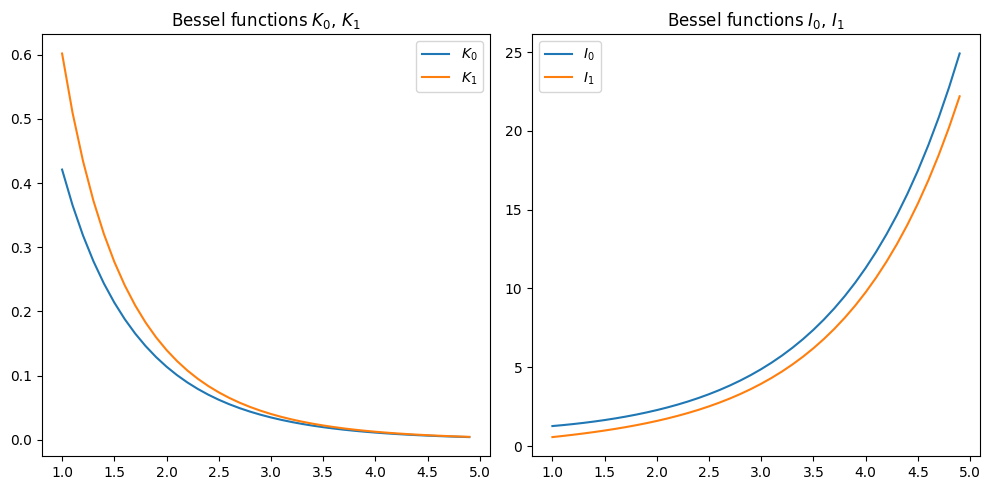

In [2]:
# построим графики модифицированных функций Бесселя
# так как функции K и I обладают разным поведением - построим на разных подграфиках
x = np.arange(1,5,0.1)

plt.rcParams["figure.figsize"] = (10,5)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(x, kn(0,x), label='$K_0$')
ax1.plot(x, kn(1,x), label='$K_1$')
ax1.set_title("Bessel functions $K_0$, $K_1$")
ax1.legend()

ax2.plot(x, iv(0,x), label='$I_0$')
ax2.plot(x, iv(1,x), label='$I_1$')
ax2.set_title("Bessel functions $I_0$, $I_1$")
ax2.legend()

plt.tight_layout()
plt.show()

In [3]:
z = sp.symbols('z')
# функция бесселя в sympy
print('функция Бесселя  K0 в sympy')
display(sp.besselk(0, z))
print('функция Бесселя  K1 это производная от функции K0')
display(sp.diff(sp.besselk(0, z), z))


функция Бесселя  K0 в sympy


besselk(0, z)

функция Бесселя  K1 это производная от функции K0


-besselk(1, z)

besselk(0, z)

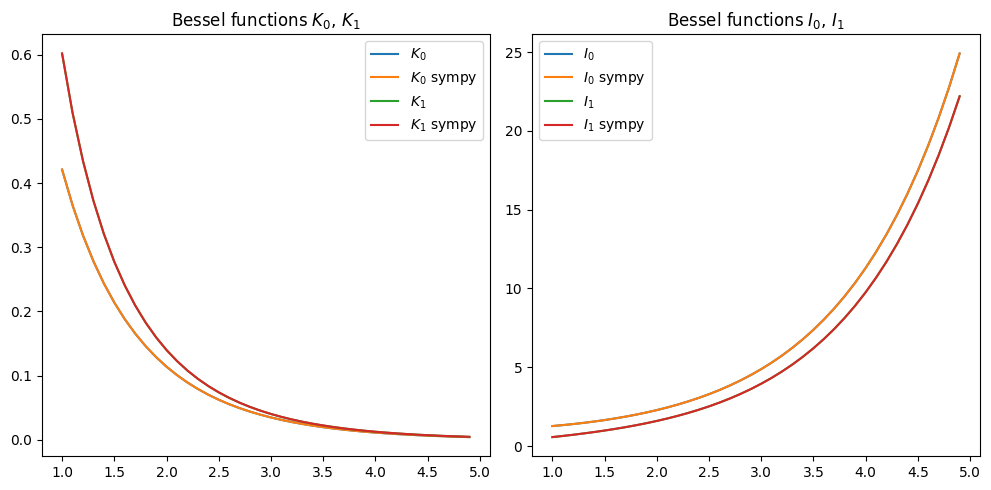

In [4]:
z = sp.symbols('z')
# функция бесселя в sympy
display(sp.besselk(0, z))
# преобразование sympy выражения в lambda функцию с использованием numpy
k0 = sp.lambdify([z], sp.besselk(0, z), modules = ['numpy', 'scipy'])
k1 = sp.lambdify([z], sp.besselk(1, z), modules = ['numpy', 'scipy'])
i0 = sp.lambdify([z], sp.besseli(0, z), modules = ['numpy', 'scipy'])
i1 = sp.lambdify([z], sp.besseli(1, z), modules = ['numpy', 'scipy'])

# построим графики модифицированных функций Бесселя
# так как функции K и I обладают разным поведением - построим на разных подграфиках
x = np.arange(1,5,0.1)

plt.rcParams["figure.figsize"] = (10,5)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(x, kn(0,x), label='$K_0$')
ax1.plot(x, k0(x), label='$K_0$ sympy')
ax1.plot(x, kn(1,x), label='$K_1$')
ax1.plot(x, k1(x), label='$K_1$ sympy')
ax1.set_title("Bessel functions $K_0$, $K_1$")
ax1.legend()

ax2.plot(x, iv(0,x), label='$I_0$')
ax2.plot(x, i0(x), label='$I_0$ sympy')
ax2.plot(x, iv(1,x), label='$I_1$')
ax2.plot(x, i1(x), label='$I_1$ sympy')
ax2.set_title("Bessel functions $I_0$, $I_1$")
ax2.legend()

plt.tight_layout()
plt.show()

## 1.3. Построение общего решения с использованием `sympy` <a class="anchor" id="13"></a>
Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right] 
$$

При переводе уравнения фильтрации в пространство Лапласа получим обыкновенное дифференциальное уравнение.


$$ 
u \widetilde{p_D}  =  \dfrac{1}{r_D} \left[\dfrac{d}{d r_D} \left(r_D \dfrac{d{\widetilde{p_D}}}{d r_D} \right) \right] 
$$

Построим общее решения уравнения Бесселя


In [5]:
# определим переменные с которыми будем работать 

t_d = sp.symbols('t_d', real=True, positive=True)
r_d = sp.symbols('r_d', real=True, positive=True)
p_d = sp.symbols('p_d', cls=sp.Function, real=True, positive=True)
Lp_d = sp.symbols(r'\widetilde{p_d}', cls=sp.Function, real=True, positive=True)
u = sp.symbols('u',real=True, positive=True)
C1, C2 = sp.symbols('C1 C2')

# определим уравнение фильтрации в пространстве Лапласа
diff_eq = sp.Eq(u * Lp_d(r_d),
                1 / r_d * (sp.diff(r_d * sp.diff(Lp_d(r_d), r_d) , r_d)) )
diff_eq

Eq(u*\widetilde{p_d}(r_d), (r_d*Derivative(\widetilde{p_d}(r_d), (r_d, 2)) + Derivative(\widetilde{p_d}(r_d), r_d))/r_d)

In [6]:
# попробуем решить уравнение 
soln = sp.dsolve(diff_eq, Lp_d(r_d))
soln

Eq(\widetilde{p_d}(r_d), C1*besseli(0, r_d*sqrt(u)) + C2*bessely(0, I*r_d*sqrt(u)))

In [7]:
# проверим, что решение полученное dsolve удовлетворяет уравнению
sp.checkodesol(diff_eq, soln)

(True, 0)

Как видно, уравнение Бесселя легко решается средствами `sympy`, 
$$\displaystyle \operatorname{p_{d}}{\left(r_{d} \right)} = C_{1} I_{0}\left(r_{d} \sqrt{u}\right) + C_{2} Y_{0}\left(i r_{d} \sqrt{u}\right)$$

Хотя полученное решение по виду и немного отличается от того, что обычно приводится в книгах. Вместо мофицированной функции Бесселя второго рода $K_0(x)$ решение выражается через функцию Бесселя второго рода $Y_0(ix)$ для мнимого арумента.

[Известны выражения](https://en.wikipedia.org/wiki/Bessel_function#Modified_Bessel_functions:_I%CE%B1,_K%CE%B1) связывающие функции Бесселя первого $J_\alpha(iz)$ и второго рода $Y_\alpha(iz)$ для мнимых аргументов с модифицированными функциями Бесселя первого $I_\alpha(z)$  и второго рода $K_\alpha(z)$.


$$ J_\alpha(iz) = e^{\frac{\alpha\pi i}{2}} I_\alpha(z)$$
$$ Y_\alpha(iz) = e^{\frac{(\alpha+1)\pi i}{2}}I_\alpha(z) - \frac{2}{\pi}e^{-\frac{\alpha\pi i}{2}}K_\alpha(z)$$

преобразуем последнее выражение

$$ Y_0(iz) = e^{\frac{\pi i}{2}}I_0(z) - \dfrac{2}{\pi}K_0(z)$$

Учитывая эти выражения можно убедиться что выражение вида 

$$ 
\tilde{p}_D(u, r_D) = A(u) K_0(r_D \sqrt u) + B(u) I_0(r_D \sqrt u)
$$

которое можно найти в книгах также будет являться общим решением уравнения фильтрации, что можно проверить командой `sympy.checkodesol`

In [8]:
# зададим в явном виде решение с использованием K_0 и I_0
A, B = sp.symbols('A B')
soln2 = sp.Eq(Lp_d(r_d) , A * sp.besselk(0, r_d * sp.sqrt(u)) + B * sp.besseli(0, r_d * sp.sqrt(u)))
soln2

Eq(\widetilde{p_d}(r_d), A*besselk(0, r_d*sqrt(u)) + B*besseli(0, r_d*sqrt(u)))

In [9]:
# проверим, что это решение также удовлетворяет исходному уравнению
sp.checkodesol(diff_eq, soln2)

(True, 0)

## 1.4. Построение частных решений уравнения фильрации. Решение радиального притока с конечным радиусом скважины в бесконечном пласте <a class="anchor" id="14"></a>

Дальше покажем как можно работать с полученным общим решением для построения частных решений. Для построения частного решения необходимо задать начальные и граничные условия. Простейшее решение можно получить задав следующие начальные и граничные условия:


Рассматривается уравнение фильтрации в безразмерных переменных 

$$ 
\frac{\partial p_D}{ \partial t_D} = \frac{1}{r_D}\left[ \frac{ \partial{}}{ \partial{r_D} }\left( r_D \dfrac{\partial p_D}{ \partial r_D} \right) \right] 
$$
1. Однородное начальное давление в нулевой момент времени
$$ p_D(t_D=0, r_D) = 0$$

2. Граничное условия на бесконечности соответствует невозмущенному пласту
$$\lim_{r_D \to \infty} p_D(r_D, t_D) = 0$$

3. Граничное условие на скважине соответствует единичному дебиту
$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ \partial p_D(r_D, t_D)}{\partial r_D} \right] = -1$$


При переводе уравнения фильтрации в пространство Лапласа преобразуется как уравнение, так и граничные условия.


$$ 
u \widetilde{p_D}  =  \dfrac{1}{r_D} \left[\dfrac{d}{d r_D} \left(r_D \dfrac{d{\widetilde{p_D}}}{d r_D} \right) \right] 
$$

1. Однородное начальное давление в нулевой момент времени при преобразовании Лапласа автоматически превратится в тождество. Дифференциальное уравнение в частных производных упростится до обыкновенного дифференциального уравнения, для решения которого необходимы только граничные условия.

2. Граничное условия на бесконечности 
$$\lim_{r_D \to \infty} \widetilde{p_D} = 0$$

3. Граничное условие на скважине
$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \widetilde{p_D}}{d r_D} \right] = -\dfrac{1}{u} $$ 



In [10]:
# проверим корректность преобразования граничного условия на скважине с использованием sympy
# граничное условие на скважине
eq_boundary = sp.Eq(r_d * sp.diff(p_d(r_d,t_d), r_d) , -1)
display(eq_boundary)

Eq(r_d*Derivative(p_d(r_d, t_d), r_d), -1)

In [11]:
# применим преобразование Лапласа к обеим частям граничного условия
eq_boundary_Laplace = sp.Eq(sp.laplace_transform(eq_boundary.lhs, t_d, u,  noconds=True) ,  
                            sp.laplace_transform(eq_boundary.rhs, t_d, u,  noconds=True))
display(eq_boundary_Laplace)

Eq(r_d*LaplaceTransform(Derivative(p_d(r_d, t_d), r_d), t_d, u), -1/u)

Общее решение уравнения фильтрации в пространстве Лапласа имеет вид

In [12]:
soln2

Eq(\widetilde{p_d}(r_d), A*besselk(0, r_d*sqrt(u)) + B*besseli(0, r_d*sqrt(u)))

Для построения частного решения надо найти функции $A$ и $B$ удовлетворив граничным условиям. 

Покажем, что граничному условию на бесконечности можно удовлетворить положив $B=0$. Для этого проверим предел общего решения на бесконечности

In [13]:
# оценка предела общего решения при стремлении r_d к бесконечности
sp.limit(soln2.rhs, r_d, sp.oo)

oo*sign(B)

Предел при призвольных  $A$ и $B$ не определен.

Положим $A=0$. Это делается командой `.subs(A, 0)` для исследуемого выражения

In [14]:
sp.limit(soln2.rhs.subs(A, 0), r_d, sp.oo)

oo*sign(B)

Получаем, что этот предел также не определен. Положим $B=0$.

In [15]:
sp.limit(soln2.rhs.subs(B, 0), r_d, sp.oo)

0

Получаем, что при $B=0$  выражение $\displaystyle \lim_{r_{d} \to \infty}\left(A K_{0}\left(r_{d} \sqrt{u}\right) + B I_{0}\left(r_{d} \sqrt{u}\right)\right) = 0$ 

Откуда можно сделать вывод, что для приведенных граничных условий $B=0$.

In [16]:
soln3 = soln2.subs(B, 0)
soln3

Eq(\widetilde{p_d}(r_d), A*besselk(0, r_d*sqrt(u)))

Найдем констранту $A$ из второго граничного условия определяющего дебит скважины

$$\lim_{r_D \to r_{wD}} \left[ r_D \dfrac{ d \widetilde{p}_D}{d r_D} \right] = -\dfrac{1}{u} $$ 

In [17]:
bc2 = sp.Eq(r_d * soln3.rhs.diff(r_d), -1/u)
bc2

Eq(-A*r_d*sqrt(u)*besselk(1, r_d*sqrt(u)), -1/u)

In [18]:
# найдем А решив алгебраическое уравнение
r_wd = sp.symbols('r_wd', real=True, positive=True)
bc2_sol = sp.solve(bc2.subs(r_d, r_wd), A)
display(bc2_sol)
# solve выдает список решений, нас интересует первое и единственное
display(bc2_sol[0])

[1/(r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u)))]

1/(r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u)))

In [19]:
#подставим полученное решение в уравнение - получим решение для произвольного радиуса скважины
soln4 = soln3.subs(A, bc2_sol[0])
soln4

Eq(\widetilde{p_d}(r_d), besselk(0, r_d*sqrt(u))/(r_wd*u**(3/2)*besselk(1, r_wd*sqrt(u))))

При $r_{wd} = 1$ получим

In [20]:
soln5 = soln4.subs(r_wd, 1)
soln5

Eq(\widetilde{p_d}(r_d), besselk(0, r_d*sqrt(u))/(u**(3/2)*besselk(1, sqrt(u))))

Если устремить радиус скважины к нулю решение можно упростить и получим решение линейного стока

In [21]:
soln6 = sp.limit(soln4.rhs, r_wd, 0)
soln6

besselk(0, r_d*sqrt(u))/u


Тогда решение для произвольного радиуса будет иметь вид
$$ \widetilde{p_D}(u, r_D) = \frac{K_0 \left( r_D \sqrt u  \right)}{u r_{wD}  \sqrt u  K_1(r_{wD} \sqrt u)} $$


Решение для бесконечно малого радиуса скважины в пространстве Лапласа будет иметь вид

$$ \widetilde{p_D}(u, r_D) = \frac{1}{u} K_0 \left( r_D \sqrt u  \right) $$

где 

$K_0$, $K_1$ - <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"
                        target="_blank" rel="noreferrer noopener">модифицированные функции Бесселя&nbsp;</a>
                        
Хотя решения в пространстве Лапласа относительно легко получить -- обратная процедура получения решения в исходных координатах на основе решения в пространстве Лапласа оказывается сложнее. Аналитически это не всегда удается сделать, чаще эту процедуру проводят численно. 

Для численного обратного преобразования Лапласа можно, например, использовать библиотеку <a href="https://mpmath.org/doc/current/calculus/inverselaplace.html"> mpmath </a>. Там же можно найти численную реализацию функций Бесселя. Но такой вариант расчета относительно медленный (смотрите пример `99_some_technical_staff.ipynb` для подробностей). Дальнейшие расчеты будут основаны на `scipy.special` и `anaflow`. 

In [22]:
# можно попробовать сделать обратное преобразование Лапласа с sympy для решения линейного стока
# но результат получается не очень красивым (остаются выражения с мнимой единицей)
# если попробовать подставить решение с конечным радиусом - оно не будет преобразовано
eqq = sp.inverse_laplace_transform(soln6, u, t_d, simplify=True)
eqq

-Ei(r_d**2*exp_polar(I*pi)/(4*t_d))/2 + I*pi/2

# 3. Построение и исследование решения линейного стока с использованием обратного преобразования Лапласа <a class="anchor" id="413"></a>

Численного обратное преобразование Лапласа удобный инструмент для построение решений уравнения фильтрации. Последующие примеры показывают как можно его использовать с python. 

In [23]:
# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_line_source(u, rd=1.):
    """
    расчет решения линейного стока для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    return np.divide(kn(0, rd * u**0.5) , u)

# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_line_source_inv(td, rd=1.):
    """
    расчет решения линейного стока для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
         должно быть числом
    результат массив массивов давления от времени
    """
    pd_inv = get_lap_inv(pd_lapl_line_source, rd=rd)
    return pd_inv(td)

In [24]:
# для сравнения приведем функции из раздела 11
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1.):
    """
    Решение линейного стока уравнения фильтрации
    td - безразмерное время, число или numpy массив, больше нуля
    rd - безразмерное расстояние, по умолчанию rd=1 - соответствует давлению на забое
         число или numpy массив
    результат массив массивов давления от времени
    """
    return -0.5 * expi(-0.25 * rd * rd / td)

#### Пример построения графиков сравнения реализаций решений линейного стока в безразмерных координатах

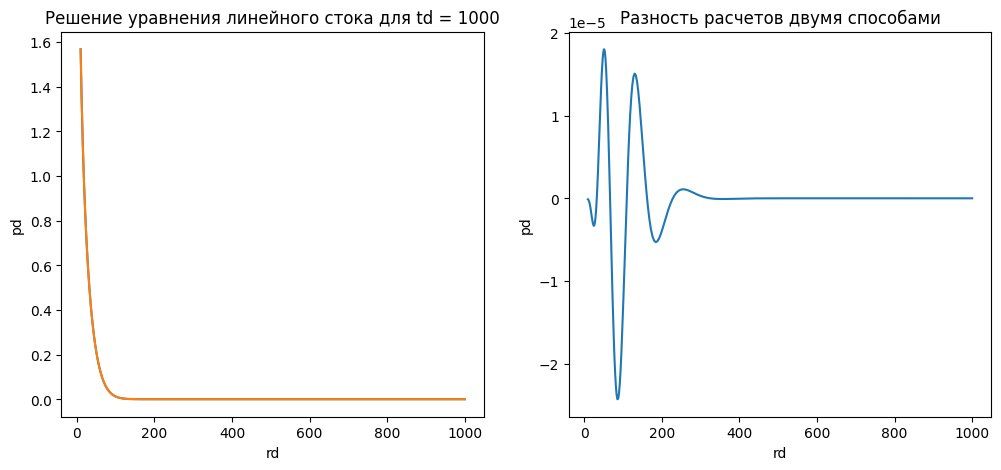

In [25]:
# построим график безразмерного давления от расстояния
# двумя способами и их разницу также
td = 1000
rd_arr = np.logspace(1, 3 ,200)
pd_ei_arr = pd_ei(td, rd_arr) 
pd_lap_inv_arr = np.squeeze([pd_line_source_inv(td, rd_i) for rd_i in rd_arr])

# при построении используем векторный расчет
plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(rd_arr, pd_ei_arr)
ax1.plot(rd_arr, pd_lap_inv_arr)
ax1.set_title("Решение уравнения линейного стока для td = {}".format(td))
ax1.set_xlabel("rd")
ax1.set_ylabel("pd")

ax2.plot(rd_arr, pd_ei_arr - pd_lap_inv_arr)
ax2.set_title("Разность расчетов двумя способами")
ax2.set_xlabel("rd")
ax2.set_ylabel("pd")

plt.show()

Построенные графики показывают, что алгоритм Стефеста для численного обратного преобразования Лапласа дает погрешность до 2e-5 или примерно в пятом знаке после запятой, что  является удовлетворительным результатом для большинства практических расчетов. 

### Определение функции для перевода размерных и безразмерных величин

In [26]:
# определим функции для перевода размерных переменных в безразмерные и обратно
# пригодится потом для построения графиков и ведения расчетов

# при наименовании функций придерживаемся следующих соглашений
# сначала идет название того, что считаем
# в конце указывается размерность результата, если это уместно

def r_from_rd_m(rd, rw_m=0.1):
    """
    перевод безразмерного расстояния в размерное
    rd -  безразмерное расстояние
    rw_m -  радиус скважины, м
    """
    return rd*rw_m

def rd_from_r(r_m, rw_m=0.1):
    """
    перевод размерного расстояния в безразмерное
    r_m - размерное расстояние, м
    rw_m - радиус скважины, м
    """
    return r_m/rw_m

def t_from_td_hr(td, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод безразмерного времени в размерное, результат в часах
    td - безразмерное время
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return td * phi * mu_cP * ct_1atm * rw_m * rw_m / k_mD / 0.00036

def td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-5, rw_m=0.1):
    """
    перевод размерного времени в безразмерное
    t_hr - размерное время, час
    k_mD - проницаемость пласта, мД
    phi - пористость, доли единиц
    mu_cP - динамическая вязкость флюида, сП
    ct_1atm - общая сжимаемость, 1/атм
    rw_m - радиус скважины, м
    """
    return  0.00036 * t_hr * k_mD / (phi * mu_cP * ct_1atm * rw_m * rw_m) 

def p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод безразмерного давления в размерное, результат в абсолютных атмосферах
    pd - безразмерное давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return pi_atma - pd * 18.41 * q_sm3day * b_m3m3 * mu_cP / k_mD / h_m 

def pd_from_p(p_atma, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250):
    """
    перевод размерного давления в безразмерное
    p_atma - давление
    k_mD - проницаемость пласта, мД
    h_m - мощность пласта, м
    q_sm3day - дебит на поверхности, м3/сут в с.у.
    fvf_m3m3 - объемный коэффициент нефти, м3/м3
    mu_cP - динамическая вязкость флюида, сП
    pi_atma - начальное давление, абсолютные атм.
    """
    return (pi_atma - p_atma) / (18.41 * q_sm3day * b_m3m3 * mu_cP) * k_mD * h_m 

#### Пример построения графиков сравнения реализаций решений линейного стока в размерных координатах

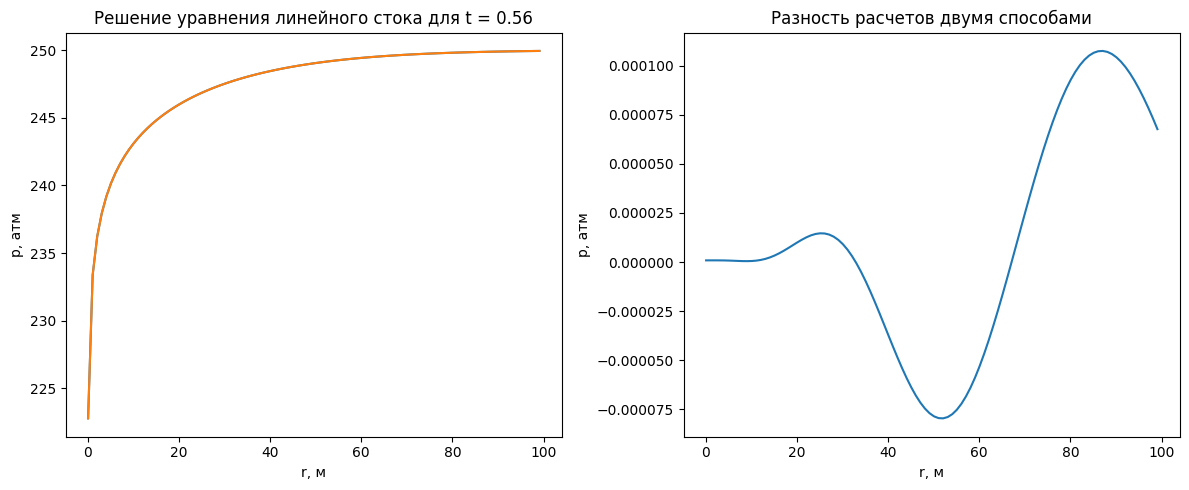

In [27]:
# построим график безразмерного давления от расстояния в безразмерных переменных
# двумя способами и их разницу также
td = 100000
rd_arr = np.arange(1, 1000 ,10)
# при построении используем векторный расчет
pd_ei_arr = pd_ei(td, rd_arr) 
pd_lap_inv_arr = np.squeeze([pd_line_source_inv(td, rd_i) for rd_i in rd_arr])

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(r_from_rd_m(rd_arr), p_from_pd_atma(pd_ei_arr) )
ax1.plot(r_from_rd_m(rd_arr), p_from_pd_atma(pd_lap_inv_arr) )

ax2.plot(r_from_rd_m(rd_arr), p_from_pd_atma(pd_ei_arr) - 
                              p_from_pd_atma(pd_lap_inv_arr))
ax1.set_title("Решение уравнения линейного стока для t = {:.2f}".format(t_from_td_hr(td)))
ax2.set_title("Разность расчетов двумя способами")
ax1.set_xlabel("r, м")
ax1.set_ylabel("p, атм")
ax2.set_xlabel("r, м")
ax2.set_ylabel("p, атм")
plt.tight_layout()
plt.show()

При переводе значений давления в размерные величины можно получить, что ошибка в пятом знаке после запятой соответствует примерно 10 Па.

## 4. Решение для конечного радиуса скважины  <a class="anchor" id="414"></a>

Решение для конечного радиуса скважины в пространстве Лапласа будет иметь вид

$$ \widetilde{p_D}(u) = \frac{K_0 \left( r_D \sqrt u  \right)}{u \sqrt u  K_1(\sqrt u)} \tag{23} $$

где 

$K_0$, $K_1$ - <a href="https://ru.wikipedia.org/wiki/%D0%9C%D0%BE%D0%B4%D0%B8%D1%84%D0%B8%D1%86%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%BD%D1%8B%D0%B5_%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8_%D0%91%D0%B5%D1%81%D1%81%D0%B5%D0%BB%D1%8F"
                        target="_blank" rel="noreferrer noopener">модифицированные функции Бесселя&nbsp;</a>

In [28]:
# пример функции реализующий расчет решения в пространстве Лапласа
def pd_lapl_finite_rw(u, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления в пространстве Лапласа
    u - переменная пространства Лапласа
    rd- безразмерное расстояние от центра скважины
    """
    # полезно учесть, что при u>5e5 выражение kn(1, u05) обратится в ноль и будет деление на ноль
    # но если принудительно сделать там выражение равное нулу, обратное преобразование Лапласа
    # может выдавать очень странные результаты, поэтому лучше пока оставить как есть
    u05 = u**0.5
    return np.divide(kn(0, rd * u05) , (u * u05 *  kn(1, u05)))


# функция расчета безразмерного давления с использованием алгоритма Стефеста
# для численного обратного преобразования Лапласа
def pd_finite_rw_inv(td, rd=1.):
    """
    расчет решения c конечным радиусом скважины для безразмерного давления
    на основе численного обратного преобразования Лапласа (алгоритм Стефеста)
    td - безразмерное давление, число или numpy массив
    rd - безразмерный радиус, по умолчанию rd=1 - соответствует давлению на забое
    результат массив массивов давления от времени
    """
    pd_inv = get_lap_inv(pd_lapl_finite_rw, rd=rd)
    return pd_inv(td)

#### Сравнение решений линейного стока и конечного радиуса скважины

Построим графики сравнения решений линейного стока и решения с учетом конечного радиуса скважины. Графики будем строить для фиксированного расстояния в зависимости от времени. 

<>:24: SyntaxWarning: invalid escape sequence '\D'
<>:24: SyntaxWarning: invalid escape sequence '\D'
C:\Users\rnt\AppData\Local\Temp\ipykernel_5360\3002054632.py:24: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel("$\Delta p$, атм")


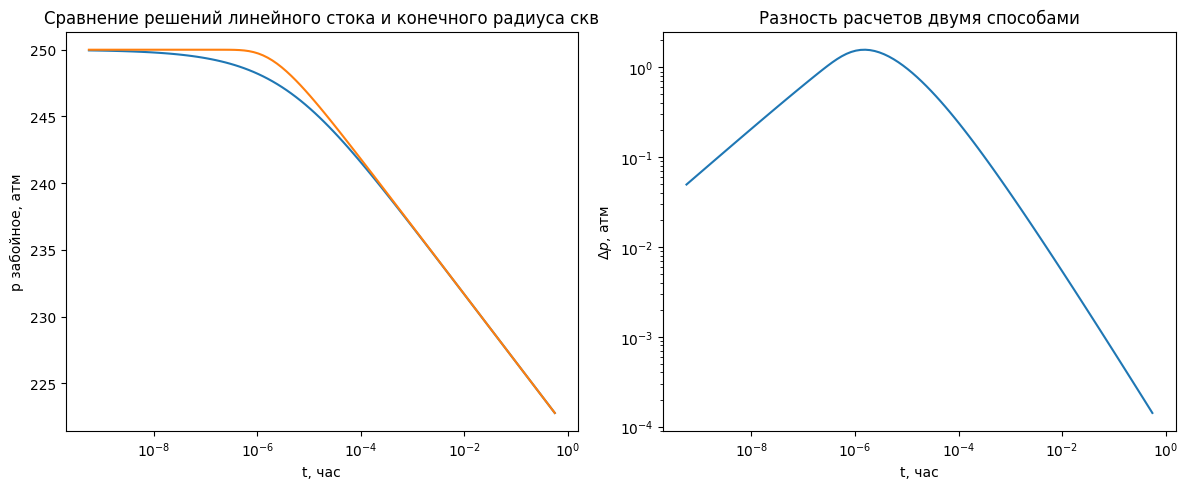

In [29]:
# построим график безразмерного давления от расстояния в безразмерных переменных
# двумя способами и их разницу также
td_arr = np.logspace(-4, 5 ,100)
rd = 1  # забойное давление

pd_finite_rw_inv_arr = pd_finite_rw_inv(td_arr, rd)
pd_line_source_inv_arr = pd_line_source_inv(td_arr, rd) 

# при построении используем векторный расчет
plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t_from_td_hr(td_arr), p_from_pd_atma(pd_finite_rw_inv_arr) )
ax1.plot(t_from_td_hr(td_arr), p_from_pd_atma(pd_line_source_inv_arr) )
ax1.set_title("Сравнение решений линейного стока и конечного радиуса скв")
ax1.set_xscale('log')
ax1.set_xlabel("t, час")
ax1.set_ylabel("p забойное, атм")

ax2.plot(t_from_td_hr(td_arr), p_from_pd_atma(pd_line_source_inv_arr) - 
                               p_from_pd_atma(pd_finite_rw_inv_arr))
ax2.set_title("Разность расчетов двумя способами")
ax2.set_xscale('log')
ax2.set_xlabel("t, час")
ax2.set_ylabel("$\Delta p$, атм")
ax2.set_yscale('log')
plt.tight_layout()
plt.show()

Видно, что для забойного давления заметные расхождения наблюдаются для времен порядка 0.001 часа или 3 секунд. Следует помнить, что данная размерная оценка получена для заданных по умолчанию параметров скважин и изменение проницаемости или сжимаемости оценку изменит. Однако проведя эксперименты можно убедиться что время для которого расхождения будет заметно все равно останется относительно малым. В этом смысле оценка сходимости решений в безразмерных переменных предпочтительна (не будет зависеть от размерных парамтеров)

Посмотрим, что будет происходить вдали от скважины - меняем только параметр `rd`

<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:21: SyntaxWarning: invalid escape sequence '\D'
C:\Users\rnt\AppData\Local\Temp\ipykernel_5360\2583577518.py:21: SyntaxWarning: invalid escape sequence '\D'
  ax2.set_ylabel("$\Delta p$, атм")


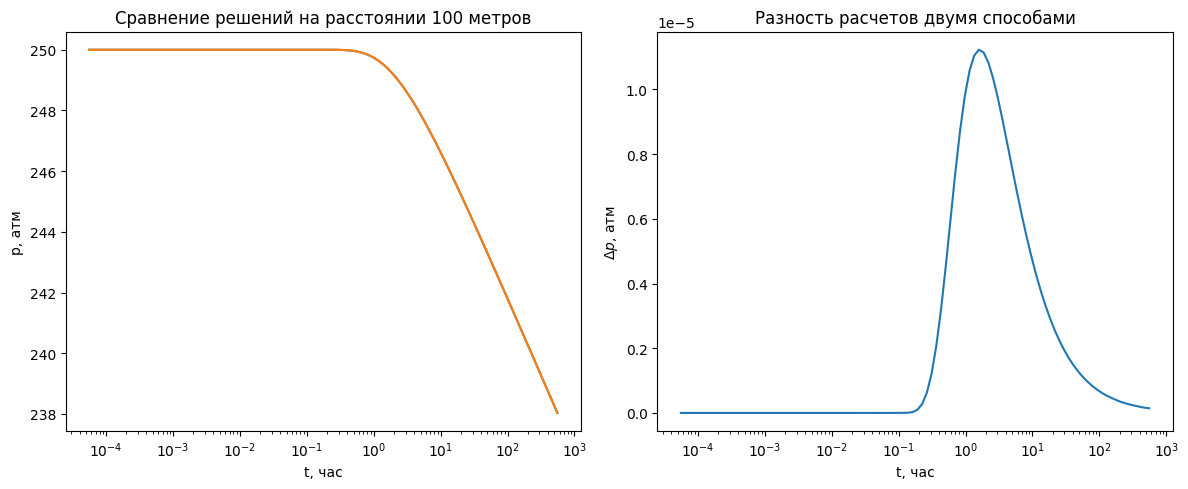

In [30]:
# построим график безразмерного давления от расстояния в безразмерных переменных
# двумя способами и их разницу также
td_arr = np.logspace(1, 8 ,100)
rd = 1000  # забойное давление
# при построении используем векторный расчет
plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(t_from_td_hr(td_arr), p_from_pd_atma(pd_finite_rw_inv(td_arr, rd)) )
ax1.plot(t_from_td_hr(td_arr), p_from_pd_atma(pd_line_source_inv(td_arr, rd)) )
ax1.set_title("Сравнение решений на расстоянии {:.0f} метров".format(r_from_rd_m(rd)))
ax1.set_xscale('log')
ax1.set_xlabel("t, час")
ax1.set_ylabel("p, атм")

ax2.plot(t_from_td_hr(td_arr),p_from_pd_atma(pd_line_source_inv(td_arr, rd)) - 
                              p_from_pd_atma(pd_finite_rw_inv(td_arr, rd)) ) 
                               
ax2.set_title("Разность расчетов двумя способами")
ax2.set_xscale('log')
ax2.set_xlabel("t, час")
ax2.set_ylabel("$\Delta p$, атм")
plt.tight_layout()
plt.show()

Видно что вдали от скважины заметных расхождений в решениях нет. Поэтому для решения задач по анализу взаимного влияния скважин широкое применение получило относительно простое решение линейного стока.